# Data Challenge: Predict Breast Cancer Cell
---

## **Introduction**

Breast Cancer Wisconsin Data Set are the measurements of cancer cell samples from Dr.Wolberg's clinical cases. In this dataset, the cells are categorized into 2 classes: benign and malignant. Each cell in the dataset has an ID number and 9 different biological measurements. All the measurements were assgined with a value range from 0-10.

The goal of this project is to build an efficient classifier to classify the breast cancer cell given the biological measurements.

###Approach

As a classification problem with small sample size, I would like to try Support vector machines (SVCs), Naive Bayes and K Nearest Neighbors (KNN), and evaluate them to pick the most appropiate one for this dataset.

---
## Step 1: data cleaning

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [0]:

%cd drive/My Drive/Data_challenge

/content/drive/My Drive/Data_challenge


### 1-1: Load the dataset into pandas dataframe

In [0]:
data = pd.read_csv('breast-cancer-wisconsin.data', sep=",",
                   names=["ID", "Thickness", "Cell_size", "Cell_shape","M_adhesion", "E_Size",
                         "Nuclei", "Chromatin", "Nucleoli", "Mitoses", "Class"])

data.head (n = 10)

,ID,Thickness,Cell_size,Cell_shape,M_adhesion,E_Size,Nuclei,Chromatin,Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2



*   Explore the shape of the dataset

In [0]:
data.shape

(699, 11)

### 1-2: Check if there are any missing or strange values in the dataset

In [0]:
data.isnull().sum()

ID            0
Thickness     0
Cell_size     0
Cell_shape    0
M_adhesion    0
E_Size        0
Nuclei        0
Chromatin     0
Nucleoli      0
Mitoses       0
Class         0
dtype: int64

* Check if there are any other strange values in the dataset

In [0]:
for item in data.columns:
  if item != 'ID' and item!= 'Class':
    print (item, ": ",(data[item].unique()))

Thickness :  [ 5  3  6  4  8  1  2  7 10  9]
Cell_size :  [ 1  4  8 10  2  3  7  5  6  9]
Cell_shape :  [ 1  4  8 10  2  3  5  6  7  9]
M_adhesion :  [ 1  5  3  8 10  4  6  2  9  7]
E_Size :  [ 2  7  3  1  6  4  5  8 10  9]
Nuclei :  ['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']
Chromatin :  [ 3  9  1  2  4  5  7  8  6 10]
Nucleoli :  [ 1  2  7  4  5  3 10  6  9  8]
Mitoses :  [ 1  5  4  2  3  7 10  8  6]


**Problem**
1.  The values in "Nuclei" are intepreted as string.
2.  There is a string value "?" which needs to be removed from the dataset.


* Check how many rows has "Nuclei" == "?"

In [0]:
data.groupby(['Nuclei']).count()

,ID,Thickness,Cell_size,Cell_shape,M_adhesion,E_Size,Chromatin,Nucleoli,Mitoses,Class
Nuclei,,,,,,,,,,
1,402,402,402,402,402,402,402,402,402,402
10,132,132,132,132,132,132,132,132,132,132
2,30,30,30,30,30,30,30,30,30,30
3,28,28,28,28,28,28,28,28,28,28
4,19,19,19,19,19,19,19,19,19,19
5,30,30,30,30,30,30,30,30,30,30
6,4,4,4,4,4,4,4,4,4,4
7,8,8,8,8,8,8,8,8,8,8
8,21,21,21,21,21,21,21,21,21,21


There are 16 rows with "?" in the column "Nuclei". In order to keep the data consistant, I am going to remove those rows and change all the rest values to integer.

In [0]:
indexNames = data[data['Nuclei'] == '?'].index
# print (indexNames)
# Delete these row indexes from data
data.drop(indexNames, inplace=True)
data['Nuclei'] = pd.to_numeric(data['Nuclei'])

In [0]:
data.shape

(683, 11)

*   The total length of our data reduced from 699 to 683.


* Next, I want to check if each cell has a unique ID.

In [0]:
print(any(data['ID'].duplicated()))   

True


In [0]:
dups = len(data['ID'])-len(data['ID'].drop_duplicates())
print (dups)

53


There are 53 cells have duplicate IDs. I don't think we need to remove the duplicates at this point. 

But in the future, I would like to get more information about those duplicates. 
1. Are they the sample cells from the same patients but at different time?
2. Do the duplicates carry important implications?

### 1-3: Check if the two classes of cell have very unbalanced sample size.

In [0]:
count = data.groupby(['Class']).count() 
count

,ID,Thickness,Cell_size,Cell_shape,M_adhesion,E_Size,Nuclei,Chromatin,Nucleoli,Mitoses
Class,,,,,,,,,,
2,444,444,444,444,444,444,444,444,444,444
4,239,239,239,239,239,239,239,239,239,239


**There are more benign cells, labelled as 2, than malignant cells, labelled as 4.** 
But the imbanlance is not extreme and I would like to continue the next step without worrying about the imbalance here.

## Step 2: Data Visualization and Explorization

For visualization, my first instinct is to explore the histogram of each feature category to see if any of them show different distribution with different class.

### 2-1: Histogram

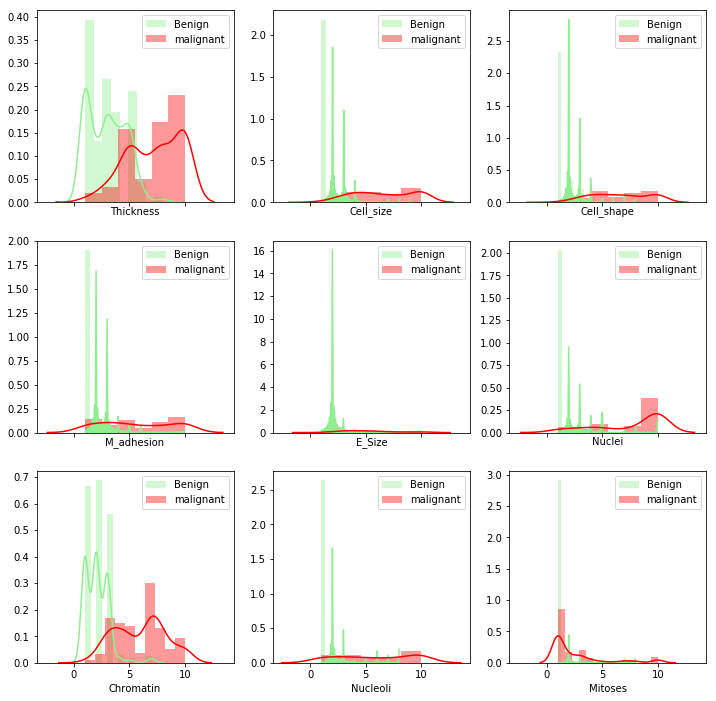

In [0]:
f, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True)
sns.distplot(data[data["Class"]==2]["Thickness"], color="lightgreen", label="Benign", ax = axes[0,0])
sns.distplot(data[data["Class"]==4]["Thickness"], color="red", label = "malignant", ax = axes[0,0])
sns.distplot(data[data["Class"]==2]["Cell_size"], color="lightgreen", label="Benign", ax = axes[0,1])
sns.distplot(data[data["Class"]==4]["Cell_size"], color="red", label = "malignant", ax = axes[0,1])
sns.distplot(data[data["Class"]==2]["Cell_shape"], color="lightgreen", label="Benign", ax = axes[0,2])
sns.distplot(data[data["Class"]==4]["Cell_shape"], color="red", label = "malignant", ax = axes[0,2])
sns.distplot(data[data["Class"]==2]["M_adhesion"], color="lightgreen", label="Benign", ax = axes[1,0])
sns.distplot(data[data["Class"]==4]["M_adhesion"], color="red", label = "malignant", ax = axes[1,0])
sns.distplot(data[data["Class"]==2]["E_Size"], color="lightgreen", label="Benign", ax = axes[1,1])
sns.distplot(data[data["Class"]==4]["E_Size"], color="red", label = "malignant", ax = axes[1,1])
sns.distplot(data[data["Class"]==2]["Nuclei"], color="lightgreen", label="Benign", ax = axes[1,2])
sns.distplot(data[data["Class"]==4]["Nuclei"], color="red", label = "malignant", ax = axes[1,2])
sns.distplot(data[data["Class"]==2]["Chromatin"], color="lightgreen", label="Benign", ax = axes[2,0])
sns.distplot(data[data["Class"]==4]["Chromatin"], color="red", label = "malignant", ax = axes[2,0])
sns.distplot(data[data["Class"]==2]["Nucleoli"], color="lightgreen", label="Benign", ax = axes[2,1])
sns.distplot(data[data["Class"]==4]["Nucleoli"], color="red", label = "malignant", ax = axes[2,1])
sns.distplot(data[data["Class"]==2]["Mitoses"], color="lightgreen", label="Benign", ax = axes[2,2])
sns.distplot(data[data["Class"]==4]["Mitoses"], color="red", label = "malignant", ax = axes[2,2])
for i in range(3):
  for j in range(3):
    axes[i,j].legend(loc = 'best')

Thickness and Chromatin seems like good features to separate the classes.

All the features are scaled from 0-10. I would like to look at the correlation matrix next.

### 2-2: Correlation matrix

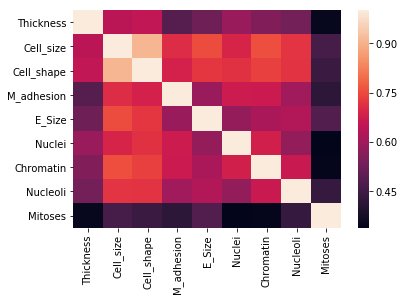

In [0]:
df = data.drop(['ID','Class'], axis=1)

corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

**From correlation matirx, cell size and shape are highly correlated with each other. Mitoses has little correlation with other features, but when comparing with the histogram, its value does not have obvious separation between different cell classes.**

## 3. Classification

For this dataset, I would like to try Naive Bayers and K Nearest Neighbor.

* Naive Bayes is a simple but powerful supervised learning algorithm. It is very powerful especially in text discrimination. However, Naive Bayes treats each feature as independent and classify the dataset based on their conditional probabilities. Some of the features in our dataset are correlated. Thus, I will try another classifier to compare.

* SVC has high accuracy, nice theoretical guarantees regarding overfitting, and with an appropriate kernel they can work well even if the data isn’t linearly separable in the base feature space. Feature scaling is a very important preprocessing step for SVC classifier.

* K Nearest Neighbor is an non parametric learning algorithm, K nearest neighbor is the first classifier came to my mind for this project. However, preprocessing steps are necessary for K Nearest Neighbor before fitting to ensure good performance. 

       KNN performs better with lower dimensionality.
       KNN can't calculate missing value in a dataset.
       KNN performs better if all the features have same scale

Based on the those rules, I am going to perform SelectKBest for K Nearest Neighbor classifier.



---

In [0]:
from sklearn.model_selection import train_test_split

### 3-1 Function: evaluate the classifiers with accuracy, recall and precision

In [0]:
def evaluate_clf(clf, features, labels, normalize = False, ave = 'binary'):
    """
    evaluate_clf is used to evaluate the performance of classifiers
    Parameters
    ----------
    clf: classifier
    features: the features that will be used in this classifier
    labels: the classfication
    normalize: default = False. If it equals true, features scaling will be
                perfromed before spliting train and test dataset
    ave: it determines the type of averaging performed on the data.
    Returns
    -------
    accuracy: the accuracy of the classifier
    recall: the ratio of true positive / (true positive + false negative)
    presicion: the ratio of true positive / (true positive + false positive)
    """
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import accuracy_score

    if normalize == True:
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        features = scaler.fit_transform(features)


    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    accuracy = accuracy_score(labels_test, pred)
    recall = recall_score(labels_test, pred, average = ave)
    precision = precision_score(labels_test, pred, average = ave)
    return accuracy, recall, precision

* Define features and labels for classification

In [0]:
X = df 
Y = data['Class'].replace({2:0, 4:1})

### 3-2: Naive Bayer

In [0]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
accuracy, recall, precision = evaluate_clf(clf_NB, X, Y)
print ("The accuracy for Naive bayes: %f" % (accuracy))
print ("The recall for Naive bayes: %f" % (recall))
print ("The precision for Naive bayes: %f" % (precision))

The accuracy for Naive bayes: 0.965854
The recall for Naive bayes: 0.961538
The precision for Naive bayes: 0.949367


### 3-3: SVC classfier

In [0]:
from sklearn.svm import LinearSVC
clf_SVC = LinearSVC(random_state=42, tol=1e-5)
accuracy, recall, precision = evaluate_clf(clf_SVC, X, Y,
normalize = True, ave = 'macro')
print ("The accuracy for SVC is: %f" % (accuracy))
print ("The recall for SVC is: %f" % (recall))
print ("The precision for SVC is: %f" % (precision))

The accuracy for SVC is: 0.956098
The recall for SVC is: 0.947254
The precision for SVC is: 0.959786


### 3-4: K Nearest Neighbors

In [0]:
from sklearn.feature_selection import SelectKBest
KB = SelectKBest(k = 5)
KB.fit(X, Y)

features_list = ['Thickness', 'Cell_size', 'Cell_shape', 'M_adhesion', 'E_Size',
       'Nuclei', 'Chromatin', 'Nucleoli', 'Mitoses']
new_list = zip(KB.get_support(), features_list, KB.scores_)
new_list = sorted(new_list, key=lambda x: x[2], reverse=True)
print ("K-best features:", new_list)


K-best features: [(True, 'Nuclei', 1426.2402697371135), (True, 'Cell_shape', 1417.6438408647628), (True, 'Cell_size', 1406.1324695730168), (True, 'Chromatin', 921.0100147383689), (True, 'Nucleoli', 727.4708050995351), (False, 'Thickness', 711.4234463367795), (False, 'M_adhesion', 677.87840028496), (False, 'E_Size', 622.1576809790224), (False, 'Mitoses', 148.78768876839013)]


In [0]:
from sklearn.neighbors import KNeighborsClassifier
KNN= KNeighborsClassifier(n_neighbors = 5)
accuracy, recall, precision = evaluate_clf(KNN, X, Y,
normalize = False)
print ("The accuracy for KNeighborsClassifier is: %f" % (accuracy))
print ("The recall for KNeighborsClassifier is: %f" % (recall))
print ("The precision for KNeighborsClassifier is: %f" % (precision))

The accuracy for KNeighborsClassifier is: 0.956098
The recall for KNeighborsClassifier is: 0.910256
The precision for KNeighborsClassifier is: 0.972603


* Test if only choose 4 features

In [0]:
new_X = X[['Nuclei', 'Cell_shape', 'Cell_size','Chromatin']]
accuracy, recall, precision = evaluate_clf(KNN, new_X, Y,
normalize = False)
print ("The accuracy for KNeighborsClassifier is: %f" % (accuracy))
print ("The recall for KNeighborsClassifier is: %f" % (recall))
print ("The precision for KNeighborsClassifier is: %f" % (precision))

The accuracy for KNeighborsClassifier is: 0.956098
The recall for KNeighborsClassifier is: 0.935897
The precision for KNeighborsClassifier is: 0.948052


### Conclusion: all 3 classifiers have very good results. Based on the evaluation, I will choose linear SVC classifer for this dataset.

### Step 4: Parameter tuning

* Cross_validation for KNeighborsClassifier

In [0]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

features_train, features_test, labels_train, labels_test = \
        train_test_split(X, Y, test_size=0.3, random_state=42)

pca = PCA ()
selection = SelectKBest ()
combined_features = FeatureUnion([("pca", pca), ("K_best", selection)])


KNN= KNeighborsClassifier()
param_grid = dict(features__pca__n_components = [1, 2, 3],
                  features__K_best__k = [1, 2, 3],
                  KNN__n_neighbors = [2, 3 , 4, 5, 6, 8])

pipeline = Pipeline([("features", combined_features), ("KNN", KNN)])

KNN_clf = GridSearchCV(pipeline,
                    param_grid=param_grid,
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    verbose=10)

KNN_clf = KNN_clf.fit(features_train, labels_train)
# print (KNN_clf.best_estimator_)
KNN_pred = KNN_clf.predict(features_test)
accuracy = accuracy_score(labels_test, KNN_pred)
recall = recall_score(labels_test, KNN_pred, average = 'macro')
precision = precision_score(labels_test, KNN_pred, average = 'macro')
print ("The accuracy of the best KNeighborsClassifier is: %f" % (accuracy))
print ("The recall of the best KNeighborsClassifier is: %f" % (recall))
print ("The precision of the best KNeighborsClassifier is: %f" % (precision))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1 
[CV]  KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1, score=0.918, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1 
[CV]  KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1, score=0.958, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1 
[CV]  KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1, score=0.947, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1 
[CV]  KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1, score=0.937, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1 
[CV]  KNN__n_neighbors=2, features__K_best__k=1, features__pca__n_components=1, score=0.947, total=   0.0s
[CV] KNN

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=1, score=0.958, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=1 
[CV]  KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=1, score=0.926, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=1 
[CV]  KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=1, score=0.947, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=2 
[CV]  KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=2, score=0.938, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=2 
[CV]  KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=2, score=0.938, total=   0.0s
[CV] KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_components=2 
[CV]  KNN__n_neighbors=2, features__K_best__k=2, features__pca__n_comp

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    3.4s finished


* Cross_validation for lSVC

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC()
param_grid = [
  {'C': [0.5, 1, 5, 10, 100, 1000],"tol":[10**-1, 10**-10], 'kernel': ['linear']},
  {'C': [0.5, 1, 5, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

SVC_clf = GridSearchCV(svc,
                    param_grid=param_grid,
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    verbose=10)

SVC_clf = SVC_clf.fit(features_train, labels_train)
# print (SVC_clf.best_estimator_)
SVC_pred = SVC_clf.predict(features_test)
accuracy = accuracy_score(labels_test, SVC_pred)
recall = recall_score (labels_test, SVC_pred, average = 'macro')
precision = precision_score(labels_test, SVC_pred, average = 'macro')
print ("The accuracy of the best SVC is: %f" % (accuracy))
print ("The recall of the best SVC is: %f" % (recall))
print ("The precision of the best SVC is: %f" % (precision))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.5, kernel=linear, tol=0.1 ...................................
[CV] ....... C=0.5, kernel=linear, tol=0.1, score=0.959, total=   0.0s
[CV] C=0.5, kernel=linear, tol=0.1 ...................................
[CV] ....... C=0.5, kernel=linear, tol=0.1, score=0.958, total=   0.0s
[CV] C=0.5, kernel=linear, tol=0.1 ...................................
[CV] ....... C=0.5, kernel=linear, tol=0.1, score=0.979, total=   0.0s
[CV] C=0.5, kernel=linear, tol=0.1 ...................................
[CV] ....... C=0.5, kernel=linear, tol=0.1, score=0.937, total=   0.0s
[CV] C=0.5, kernel=linear, tol=0.1 ...................................
[CV] ....... C=0.5, kernel=linear, tol=0.1, score=0.989, total=   0.0s
[CV] C=0.5, kernel=linear, tol=1e-10 .................................
[CV] ..... C=0.5, kernel=linear, tol=1e-10, score=0.959, total=   0.0s
[CV] C=0.5, kernel=linear, tol=1e-10 .................................
[CV] ..... C=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV] C=5, kernel=linear, tol=1e-10 ...................................
[CV] ....... C=5, kernel=linear, tol=1e-10, score=0.938, total=   0.0s
[CV] C=5, kernel=linear, tol=1e-10 ...................................
[CV] ....... C=5, kernel=linear, tol=1e-10, score=0.979, total=   0.0s
[CV] C=5, kernel=linear, tol=1e-10 ...................................
[CV] ....... C=5, kernel=linear, tol=1e-10, score=0.937, total=   0.0s
[CV] C=5, kernel=linear, tol=1e-10 ...................................
[CV] ....... C=5, kernel=linear, tol=1e-10, score=0.989, total=   0.0s
[CV] C=10, kernel=linear, tol=0.1 ....................................
[CV] ........ C=10, kernel=linear, tol=0.1, score=0.959, total=   0.0s
[CV] C=10, kernel=linear, tol=0.1 ....................................
[CV] ........ C=10, kernel=linear, tol=0.1, score=0.938, total=   0.0s
[CV] C=10, kernel=linear, tol=0.1 ....................................
[CV] ........ C=10, kernel=linear, tol=0.1, score=0.979, total=   0.0s
[CV] C

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   18.3s finished


# Conclusions 

**The best classifier is KNN in this project. **